# Selezione del modello

In questo notebook proveremo alcuni metodi di selezione dei modelli. Partendo dai due modelli con le migliori performance del notebook 3 cercheremo i valori ottimali degli iperparametri, valutando varie configurazioni tramite cross-validation. Successivamente testeremo la migliore configurazione sul test set.

Per prima cosa importiamo i dati e alcune librerie.

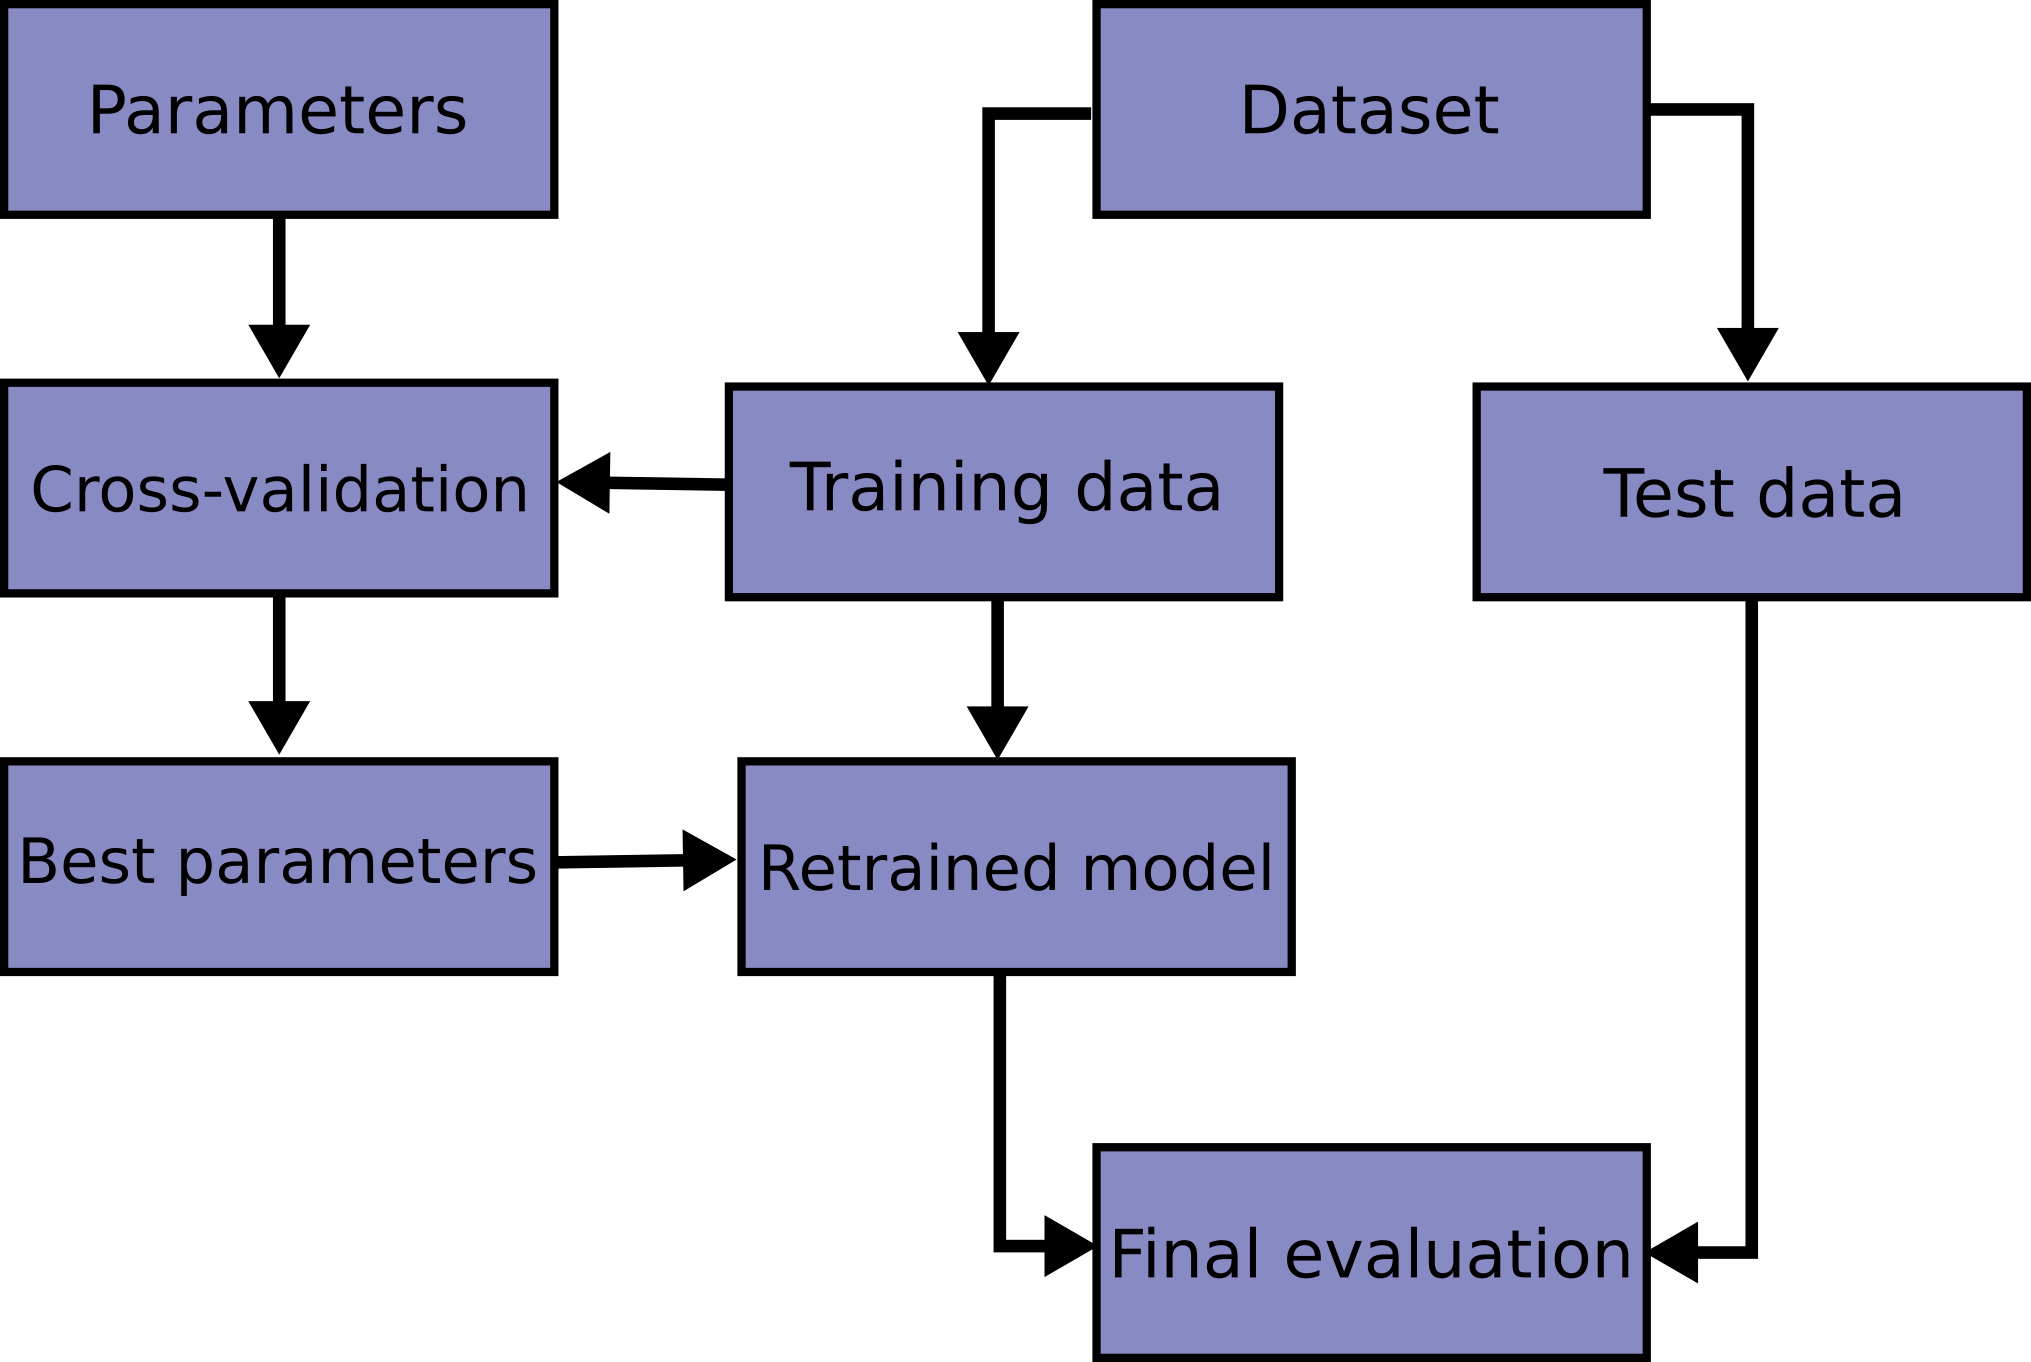

In [1]:
import warnings
import os 
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def get_data(filename:str) -> tuple:
    path = os.path.join("datasets", filename)
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data

In [3]:
classification_data = get_data("classification_data.pickle")
regression_data = get_data("regression_data.pickle")

## Selezione degli iperparametri - Classificazione

Nel notebook precedente abbiamo scelto `RandomForestClassifier` come modello principale per il problema di classificazione. 
Ora selezioneremo gli iperparametri del modello tramite lo score di 5-fold cross-validation sul train set.

In genere questo processo viene svolto congiuntamente alla selezione del modello candidato, in modo da avere una visione più completa delle possibili performance del modello.

A tale scopo utilizzeremo la funzione `cross_val_score` di `sklearn`, che ci permette di automatizzare il processo di cross-validation.

In [ ]:
X_train, y_train, X_test, y_test = classification_data

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

# Perform a 10-fold cross validation
scores = cross_val_score(rfc, X_train, y_train, cv=10)

In [ ]:
scores = pd.DataFrame(scores, columns=["Random Forest CV"], index=np.arange(1, scores.shape[0]+1))
display(scores, f"Mean: {scores.mean()}")
scores.plot.hist()

Applichiamo ora il metodo per trovare dei buoni parametri per il modello. A tale scopo dovremo scegliere uno spazio dei parametri da esplorare e un metodo per farlo. Qui proponiamo 3 approcci possibili.

### Metodo 1 - GridSearchCV

Utilizzeremo il metodo `GridSearchCV` di `sklearn`, che permette di esplorare uno spazio dei parametri con una ricerca esaustiva.

In [ ]:
params = {
    # 'n_estimators' rappresenta il numero di alberi nella foresta. Di solito il
    # numero più alto di alberi è il migliore per apprendere i dati. Tuttavia, 
    # aggiungendo molti alberi può rallentare notevolmente il processo di addestramento, 
    # quindi di solito usiamo un numero ragionevole a seconda delle dimensioni del dataset.
    'n_estimators': [10, 100, 500],

    # 'max_depth' rappresenta la profondità di ciascun albero nella foresta. 
    # Più profondo è l'albero, più suddivisioni ha e cattura più informazioni sui dati 
    # e questa è la profondità massima a cui può crescere ciascun albero.
    'max_depth': [1,3,5],

    # 'min_samples_split' rappresenta il numero minimo di campioni necessari per dividere un nodo interno.
    # Questo può variare tra considerare almeno un campione in ciascun nodo 
    # a considerare tutti i campioni in ciascun nodo. Quando aumentiamo questo parametro,
    # l'albero diventa più vincolato in quanto deve considerare più campioni in ciascun nodo.
    'min_samples_split': [2, 5],

    # 'min_samples_leaf' è il numero minimo di campioni richiesti per essere in un nodo foglia.
    # Questo parametro è simile a min_samples_splits, tuttavia, descrive il numero minimo di
    # campioni alle foglie, alla base dell'albero.
    'min_samples_leaf': [2, 4],

    # 'max_features' rappresenta il numero di caratteristiche da considerare quando si cerca
    # la migliore suddivisione. Queste saranno selezionate in modo casuale. 
    # Come regola generale, la radice quadrata del numero totale di caratteristiche funziona
    # spesso molto bene, ma dovremmo controllare fino al 30-40% del numero totale di features.
    'max_features': ['sqrt', 'log2'],

    # 'bootstrap' viene utilizzato per il campionamento avviato. Ciò significa che per ogni albero
    # che viene costruito, considererebbe un insieme / sottoinsieme di righe distinte. Generalmente, 
    # l'opzione di avvio è impostata su True per un modello Random Forest.
    'bootstrap': [True, False],

    # 'criterion' è la funzione per misurare la qualità di una divisione. "gini" è per l'impurità di Gini 
    # e "entropy" è per il guadagno di informazione.
    'criterion': ['gini', 'entropy']
}

# Una funzione per contare il numero di combinazioni possibili:

def count_combinations(params: dict)-> int:

    result = 1
    for key in params:
        subset_count = 1
        if isinstance(params[key], list):
            subset_count=len(params[key])
        elif isinstance(params[key], dict):
            subset_count=count_combinations(params[key])
        result*=subset_count
    return result

display(count_combinations(params))
        

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=params, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

Ora possiamo estrarre la configurazione ottimale dall'oggetto:

In [ ]:
best_params = grid_search.best_params_
print("Best hyperparameters:\n",best_params,"\nwith GridSearchCV best score: {:.2%}".format(grid_search.best_score_))

Ora possiamo allenare il modello con la configurazione ottimale su tutto il train set e testarlo sul test set.

In [ ]:
# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False);
print(classification_report(y_test, y_pred))

### Metodo 2 - RandomizedSearchCV

A volte, specie se lo spazio dei parametri è molto grande e/o il modello complesso da allenare, la ricerca esaustiva può diventare estremamente costosa. Potrebbe quindi essere più ragionevole campionare lo spazio degli iperparametri. Un possibile metodo è il campionamento casuale di `RandomizedSearchCV`. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

more_params = {
    "n_estimators": list(range(400,601, 10)),
    "max_depth": list(range(3,11)),
    "min_samples_split": list(range(2,4)),
    "min_samples_leaf": list(range(3,6)),
    "max_features": ["sqrt"],
    "bootstrap": [True],
    "criterion": ["gini"],
}
print(count_combinations(more_params))

In [ ]:

random_search = RandomizedSearchCV(
    rfc, more_params, n_iter=100, cv=5, n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

Come prima estraiamo la combinazione ottimale, fittiamo sul train e calcoliamo lo score.

In [ ]:
best_params = random_search.best_params_
print("Best hyperparameters:\n",best_params,"\nwith GridSearchCV best score: {:.2%}".format(grid_search.best_score_))

In [ ]:
# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False);
print(classification_report(y_test, y_pred))

### Metodo 3 - Ray

[Ray](https://docs.ray.io/en/latest/tune/index.html) è una libreria che offre diverse funzionalità utili per la creazione di modelli di ML, come gestione del training distribuito, logging e ottimizzazione degli iperparametri. 

Nel nostro caso utilizzeremo l'algoritmo offerto dalla libreria [Hyperopt](http://hyperopt.github.io/hyperopt/), che utilizza un metodo chiamato [Tree Parzen Estimator](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

Per prima cosa dobbiamo preparare lo spazio dei parametri da utilizzare. A differenza dei metodi precedenti, in questo caso i range delle singole variabili vanno specificati usando gli [strumenti offerti dalla libreria](https://docs.ray.io/en/latest/tune/api/search_space.html).

In [4]:
from ray import tune, train

search_space = {
    "n_estimators": tune.lograndint(10, 1000),
    "max_depth": tune.randint(1,10),
    "min_samples_split":tune.randint(2,10),
    "min_samples_leaf": tune.randint(1,10),
    "max_features": tune.choice(["sqrt", "log2"]),
    "bootstrap": tune.choice([True, False]),
    "criterion": tune.choice(["gini","entropy"]),
}

Ora costruiamo la funzione che Ray andrà ad ottimizzare.

In [ ]:
def objective(config):
    score = cross_val_score(RandomForestClassifier(**config), X_train, y_train, cv=5)
    train.report({"score": score.mean()})

Ora possiamo ottimizzare questa funzione (quindi massimizzare lo score rispetto agli iperparametri) utilizzando la classe `Tuner`.

In [5]:
from ray.tune.search.hyperopt import HyperOptSearch

tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        search_alg=HyperOptSearch(random_state_seed=42),
        num_samples=100,
        metric="score",
        mode = "max",
    ),
    param_space=search_space
)

results=tuner.fit()

NameError: name 'objective' is not defined

Infine valutiamo le performance del modello con questi parametri, allenato sul train set e valutato sul test set.

In [ ]:
best_score = results.get_best_result().metrics["score"]
best_params = results.get_best_result().config
print("Best hyperparameters:\n",best_params,"\nwith GridSearchCV best score: {:.2%}".format(best_score))

# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
print(classification_report(y_test, y_pred))

Notiamo che, fra i tre metodi, questo ci ha dato il modello migliore in tempi minimali.

## Selezione degli iperparametri - Regressione

Ripetiamo ora il processo appena attuato, questa volta per il nostro modello di regressione, `XGBRegressor`. Dato che conosciamo già i metodi principali, ci concentreremo sull'arricchire le informazioni ottenute dalla cross-validation, perciò useremo la funzione `cross_validate` di `sklearn`.

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

# Importiamo i dati necessari
X_train, y_train, X_test, y_test = regression_data

# Testiamo cross_validate
score_names = ["neg_mean_squared_error","neg_root_mean_squared_error", "neg_mean_absolute_error"]
scores = cross_validate(XGBRegressor(), X_train, y_train, cv=5, scoring=score_names)
display(scores)

{'fit_time': array([0.08252168, 0.05909204, 0.05009365, 0.06227779, 0.05245137]),
 'score_time': array([0.00686288, 0.00328612, 0.00407457, 0.00536823, 0.00342965]),
 'test_neg_mean_squared_error': array([-1.41628439, -2.66110921, -0.38759963, -0.91252604, -0.28571479]),
 'test_neg_root_mean_squared_error': array([-1.19007747, -1.63129066, -0.622575  , -0.95526229, -0.53452296]),
 'test_neg_mean_absolute_error': array([-0.57554626, -0.79032822, -0.30618487, -0.48815309, -0.24714826])}

Notiamo alcune cose:

- La funzione `cross_validate` ci dà più informazioni riguardo a ciascuna fold dei dati
- Questa funzione ci permette di usare più di una metrica alla volta
- Le metriche di regressione rese disponibili da `sklearn` hanno il segno negativo (quindi vogliamo massimizzarle).

Possiamo ora passare alla selezione degli iperparametri usando `ray`, questa volta con più informazioni disponibili.

In [15]:
# Creiamo uno spazio di iperparametri da esplorare
search_space = {
    # Il numero di alberi da costruire
    "n_estimators": tune.choice([100, 200, 300, 400, 500]),
    # La profondità massima di ogni albero
    "max_depth": tune.randint(1,7),
    # Il tasso di apprendimento, che controlla il peso dei nuovi alberi aggiunti al modello
    "learning_rate": tune.loguniform(0.001, 0.1),
    # Il parametro di regolarizzazione che riduce l'overfitting penalizzando i pesi degli alberi
    "gamma": tune.uniform(0, 1),
    # Il parametro di regolarizzazione L2 che controlla la complessità dei pesi delle foglie
    "reg_lambda": tune.uniform(0, 10),
    # Il parametro di regolarizzazione L1 che controlla la sparsità dei pesi delle foglie
    "reg_alpha": tune.uniform(0, 10),
    # La frazione di osservazioni da campionare per ogni albero
    "subsample": tune.uniform(0.5, 1),
    # La frazione di colonne da campionare per ogni albero
    "colsample_bytree": tune.uniform(0.5, 1),
    # La funzione obiettivo da usare per il modello (ad esempio regressione lineare o regressione logistica)
    "objective": tune.choice(["reg:squarederror", "reg:pseudohubererror"]),
}

# Definiamo una nuova funzione obiettivo

output_score_names = ["test_"+name for name in score_names]

def fix_scores(scores):
    fixed_scores = dict()
    for key in scores:
        if "test_" in key:
            fixed_scores[key.replace("test_neg", "")]=scores[key].mean()
        else:
            fixed_scores[key]=scores[key].mean()

def objective(config):
    scores = cross_validate(XGBRegressor(**config), X_train, y_train, cv=5, scoring=score_names)
    fixed_scores = fix_scores(scores)
    train.report(fixed_scores)

tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        search_alg=HyperOptSearch(random_state_seed=42),
        num_samples=10,
        metric="root_mean_squared_error",
        mode = "max",
    ),
    param_space=search_space,

)

results=tuner.fit()


2023-10-05 16:16:14,176	ERROR tune_controller.py:1502 -- Trial task failed for trial objective_08d78d33
Traceback (most recent call last):
  File "/home/dev/projects/Python-Data-Science/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/dev/projects/Python-Data-Science/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/dev/projects/Python-Data-Science/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/dev/projects/Python-Data-Science/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2547, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=65244, ip=172.19.222.174, actor_id=8b70768a649cf8558f9d797a01000000, repr=objective)
  File "